### Replicates the 3 state model case with Refactored Code

In [1]:
import numpy as np

In [2]:
pwd

'C:\\Python Files\\AluminaConcEstimator\\NoteBooks'

In [3]:
import sys
sys.path.append('../')

In [4]:
from Refactor.Properties import ValidProperty, CellProperties
from Refactor.Model import VariableVector, ControlMatrix, clone_vector
from Refactor.CellVoltage import VIcell
from numpy.linalg import inv
from scipy.linalg import cholesky, LinAlgError

In [5]:
# Need to define the cell first
bbcell = CellProperties()

In [6]:
# need to extract gamma to define the control matrices - it has dependency on a valid CE
gamma, validg = bbcell.gamma
print(gamma, validg)

1.664337575188073e-05 True


In [7]:
# Create initial State Vector Variables for the 3 state model
x0 = VariableVector(cAl2O3=3.5, uAl2O3=0.5, ACD= 2.9193)
x0.dictionary

{'cAl2O3': 0, 'uAl2O3': 1, 'ACD': 2}

In [8]:
# Create Input Vector Variables
u0 = VariableVector(I=126000.0, g=0.0, B=0.0)
u0.dictionary

{'I': 0, 'g': 1, 'B': 2}

In [9]:
# Create Measurement Vector Variables
z0 = VariableVector(Vcell=4.465858)
z0.dictionary

{'Vcell': 0}

In [10]:
# Define the F matrix for 3 state model with first order dependency on dT
F = ControlMatrix(3, 3, 1)
# Identity matrix for the terms independent of dT
F.set_array_layer(0, np.identity(3, dtype=float))

True

In [11]:
# first order dependency on dT in layer 1
F.set_array_layer(1, np.array([[0.0, bbcell.kdiss, 0.0], [0.0, -bbcell.kdiss, 0.0], [0.0, 0.0, 0.0]]))

True

In [12]:
F.array_display

array([[[ 1.   ,  0.   ,  0.   ],
        [ 0.   ,  1.   ,  0.   ],
        [ 0.   ,  0.   ,  1.   ]],

       [[ 0.   ,  0.002,  0.   ],
        [ 0.   , -0.002,  0.   ],
        [ 0.   ,  0.   ,  0.   ]]])

In [13]:
F.array_eval(5)

array([[1.  , 0.01, 0.  ],
       [0.  , 0.99, 0.  ],
       [0.  , 0.  , 1.  ]])

In [14]:
# Define G with simple 3 terms, diagonal "dT"
G = ControlMatrix(3, 3, 1)
G.set_array_layer(0, np.zeros((3,3)))
G.set_array_layer(1, np.identity(3, dtype=float))

True

In [15]:
G.array_eval(5)

array([[5., 0., 0.],
       [0., 5., 0.],
       [0., 0., 5.]])

In [16]:
B = ControlMatrix(3, 3, 1)
B.set_array_layer(0, np.array([[0.0, 100*(1-bbcell.r)/bbcell.m, 0.0], [0.0, 100*bbcell.r/bbcell.m, 0.0], [0.0, 0.0, 1.0]]))
B.set_array_layer(1, np.array([[-gamma/bbcell.m, 0.0, 0.0], [0.0, 0.0, 0.0], [bbcell.alpha, 0.0, 0.0]]))

True

In [17]:
B.array_eval(5)

array([[-4.62315993e-08,  2.22222222e-02,  0.00000000e+00],
       [ 0.00000000e+00,  3.33333333e-02,  0.00000000e+00],
       [-1.64690382e-10,  0.00000000e+00,  1.00000000e+00]])

In [18]:
# Define the noise standard deviations for simulation purposes (ie relatively low by factor of 2-10
q1dstd = 0.0002    # alumina concentration variation
q1ustd = 0.0001    # undisolved alumina concentration variation
q2std = 0.0000001  # acd varation needs to be much lower
Q = ControlMatrix(3, 3, 0)
Q.set_array_layer(0, np.array([[q1dstd**2, 0.0, 0.0], [0.0, q1ustd**2, 0.0], [0.0, 0.0, q2std**2]]))
Q.array_display

array([[[4.e-08, 0.e+00, 0.e+00],
        [0.e+00, 1.e-08, 0.e+00],
        [0.e+00, 0.e+00, 1.e-14]]])

In [19]:
# Define the measurement standard deviations (again factor of 2 less variation for sim)
rstd = 0.001      # measurement variation (volts)
R = ControlMatrix(1, 1, 0)
R.set_array_layer(0, np.array([[rstd**2]]))
R.array_display

array([[[1.e-06]]])

In [20]:
from Refactor.UKFClass import DiscreteModel

In [21]:
alumina3state = DiscreteModel(F, B, G, Q, R, z0, u0, x0)

In [22]:
alumina3state.defined

True

In [23]:
from Refactor.UKFClass import UKF, ukf_unpack, ukf_zpack, ukf_execute

In [24]:
from Refactor.Simulation import sim_nofeeding, plot_xsim, sim_observation, plot_zsim

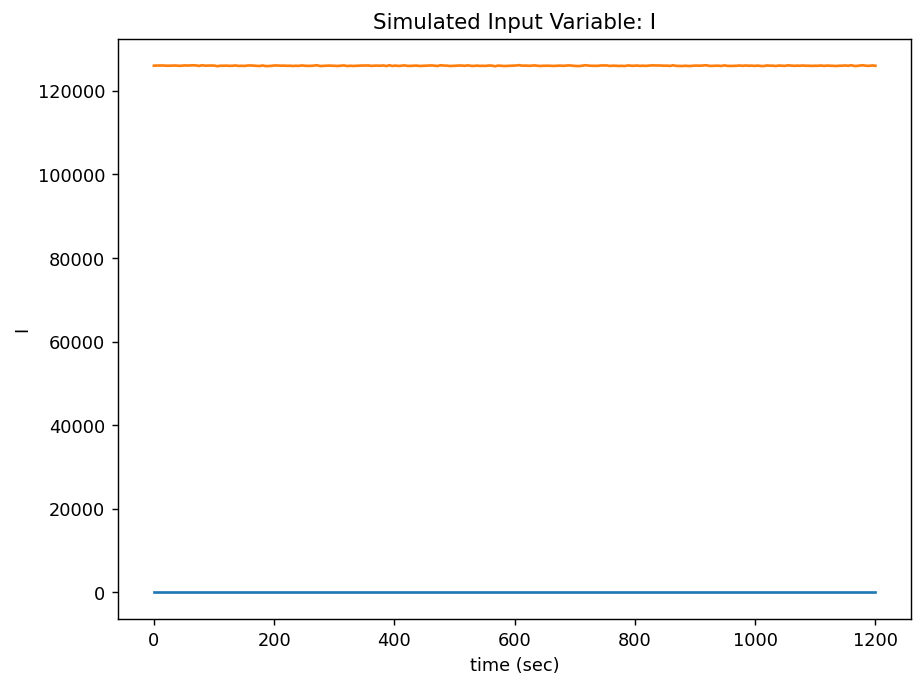

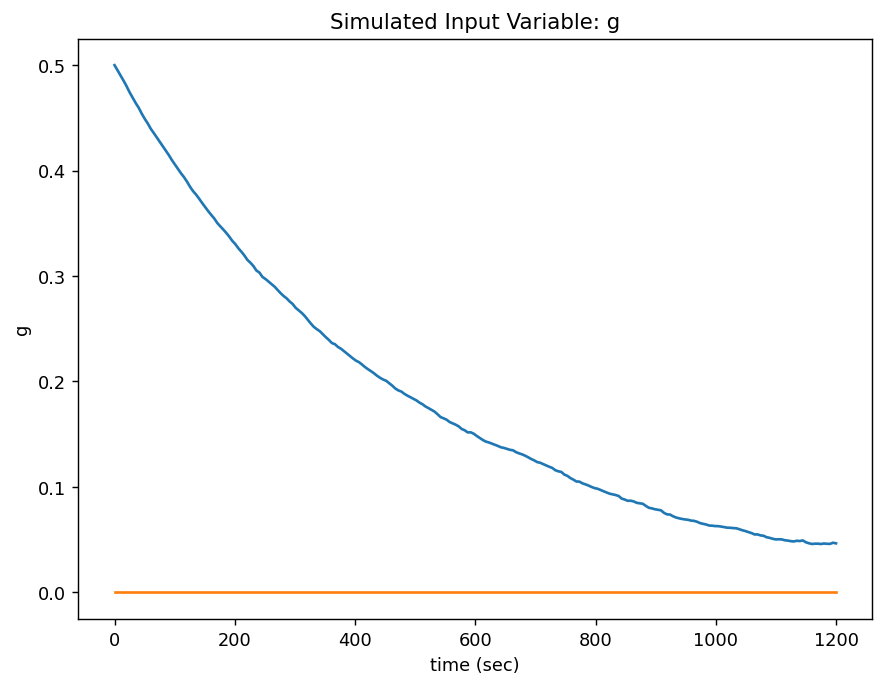

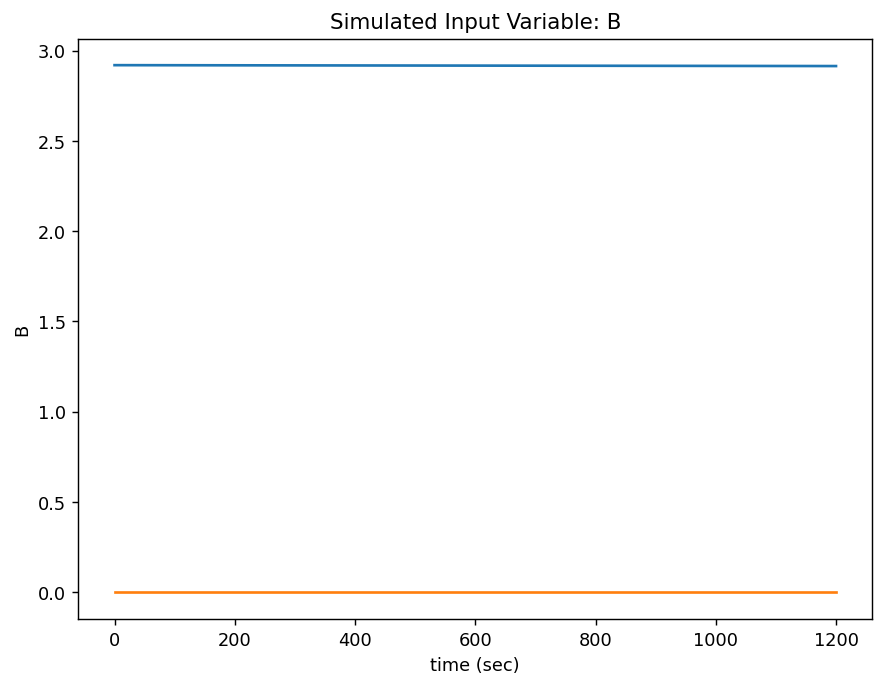

In [25]:
x, u = sim_nofeed(5, 240, bbcell, alumina3state, u0, x0, Istd=50, plotresult=True)

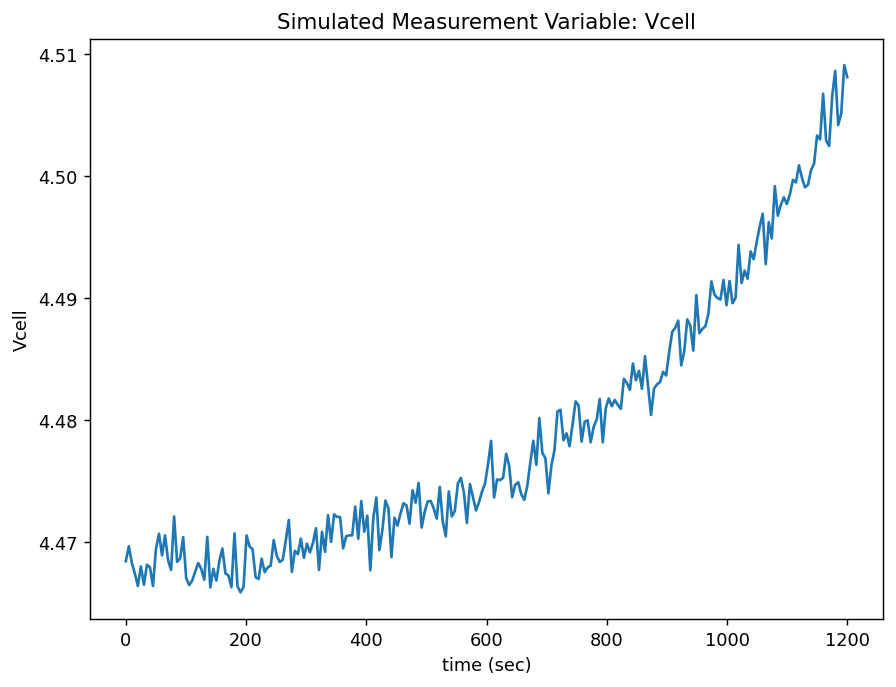

In [26]:
z = sim_observation(5, x, u, bbcell, alumina3state, plotresult=True)

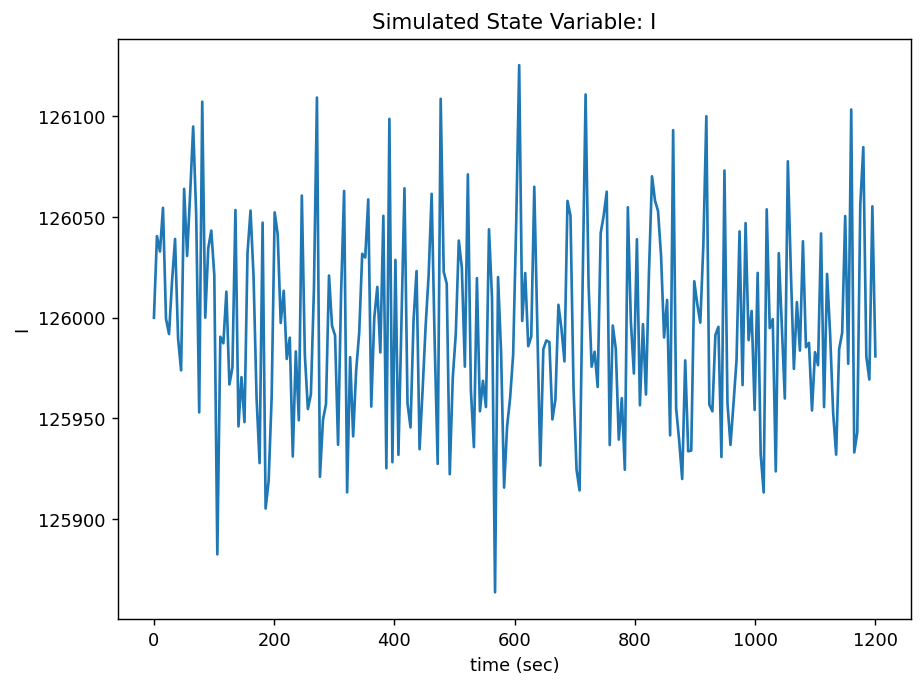

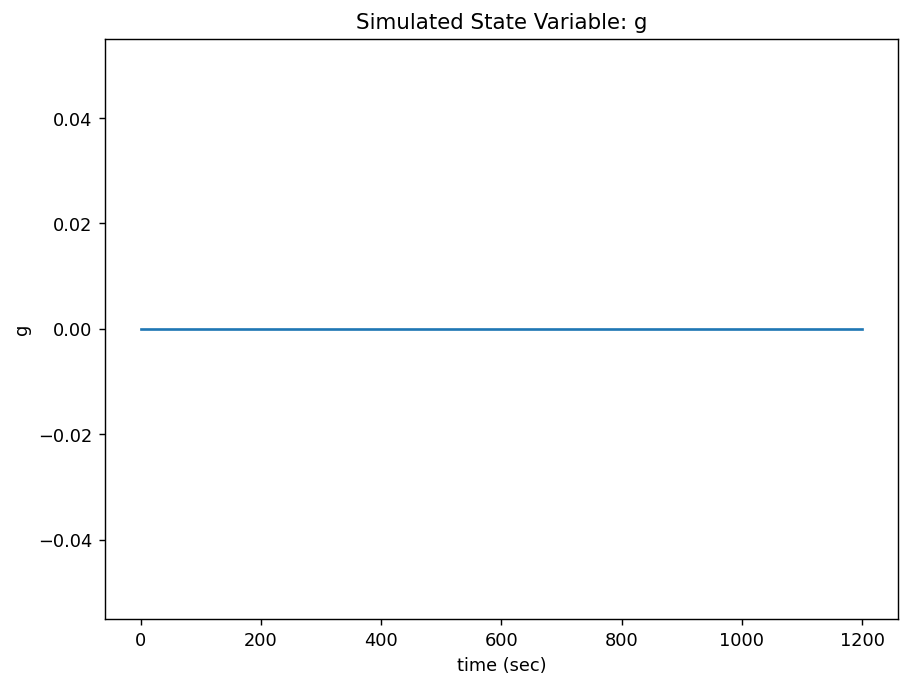

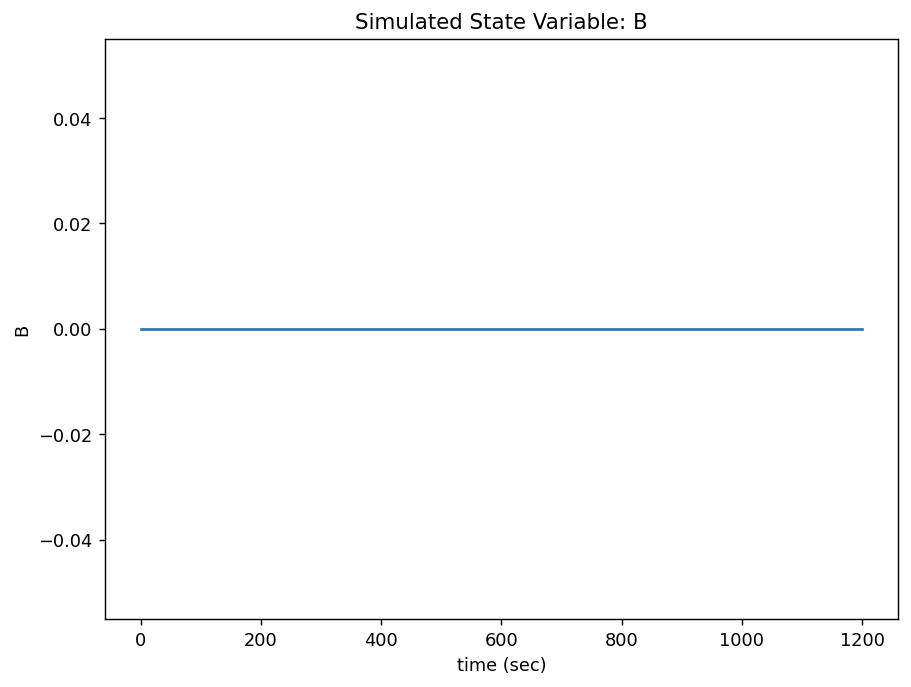

In [27]:
# note the labelling on these charts says "state" but should read "input"
plot_xsim(list(u0.dictionary.keys()), u, 5)

In [28]:
# now need to repackage the simulation to suit the 4 state model. But first lets define the 4-state model

In [29]:
# Create initial State Vector Variables
x4s0 = VariableVector(cAl2O3=3.5, deltag_rate=0.04, ACD=2.9193, deltaI=0.0)
x4s0.dictionary

{'cAl2O3': 0, 'deltag_rate': 1, 'ACD': 2, 'deltaI': 3}

In [30]:
# Create Input Vector Variables
u4s0 = VariableVector(g0=0.0, B=0.0, I0=126000.0, )
u4s0.dictionary

{'g0': 0, 'B': 1, 'I0': 2}

In [31]:
# Create Measurement Vector Variables
z4s0 = VariableVector(Vcell=4.465858, Icell=126000.0)
z4s0.dictionary

{'Vcell': 0, 'Icell': 1}

In [32]:
# need to map the simualtion to the 4 state model

In [33]:
np.shape(x)

(240, 3, 1)

In [34]:
xt = np.zeros((240, 4, 1), dtype=float)

In [35]:
np.shape(xt)

(240, 4, 1)

In [36]:
x0.dictionary

{'cAl2O3': 0, 'uAl2O3': 1, 'ACD': 2}

In [37]:
x4s0.dictionary

{'cAl2O3': 0, 'deltag_rate': 1, 'ACD': 2, 'deltaI': 3}

In [38]:
xt[:, 0:3, :] = x[:, 0:3, :]

In [39]:
xt[:, 1, :] = xt[:, 1, :]/100

In [40]:
u0.dictionary

{'I': 0, 'g': 1, 'B': 2}

In [41]:
u4s0.dictionary

{'g0': 0, 'B': 1, 'I0': 2}

In [42]:
deltaI = u[:, 0, :] - 126000

In [43]:
xt[:, 3, :] = deltaI

In [44]:
ut = np.zeros((240, 3, 1), dtype=float)

In [45]:
ut[:, 2, :] = u[:, 0, :] - deltaI

In [46]:
zt = np.zeros((240, 2, 1), dtype=float)

In [47]:
zt[:, 0, :] = z[:, 0, :]
zt[:, 1, :] = u[:, 0, :]

In [48]:
x4s0.setvector(xt[0])

True

In [49]:
x4s0.vector

array([[3.5   ],
       [0.005 ],
       [2.9193],
       [0.    ]])

In [50]:
z4s0.setvector(zt[0])

True

In [51]:
z4s0.vector

array([[4.46842961e+00],
       [1.26000000e+05]])

In [52]:
# Now need to define the 4 state model and see that with the simulated true xt, ut we get plausible zt

### Retained delta_I dependency on previous value for the UKF model case

In [53]:
# Define the F matrix for 4 state model with first order dependency on dT
F = ControlMatrix(4, 4, 1)
# Identity matrix for the terms independent of dT, except the delta I term
F0 = np.identity(4, dtype=float)
# F0[3, 3] = 0.0
F.set_array_layer(0, F0)

True

### Corrected 2nd term first row for dimensional consistency and conservation of mass

In [54]:
# first order dependency on dT in layer 1
kdeltag = 0.02
F.set_array_layer(1, np.array([[0.0, 100/bbcell.m, 0.0, -gamma/bbcell.m],
                               [0.0, -(bbcell.kdiss + kdeltag*0), 0.0, 0.0],
                               [0.0, 0.0, 0.0, bbcell.alpha],
                               [0.0, 0.0, 0.0, 0.0]]))

True

In [55]:
# evaluate F with dT = 5 sec
F.array_eval(5)

array([[ 1.00000000e+00,  2.77777778e-01,  0.00000000e+00,
        -4.62315993e-08],
       [ 0.00000000e+00,  9.90000000e-01,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        -1.64690382e-10],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [56]:
# Simple noise model - dT terms on the diagonal
G = ControlMatrix(4, 4, 1)
G.set_array_layer(0, np.zeros((4,4)))
G.set_array_layer(1, np.identity(4, dtype=float))

True

In [57]:
# evaluate G with dT = 5 sec
G.array_eval(5)

array([[5., 0., 0., 0.],
       [0., 5., 0., 0.],
       [0., 0., 5., 0.],
       [0., 0., 0., 5.]])

### Corrected first element for dimensional consistency (wt%)

In [58]:
# input control matrix for 4 states, 3 inputs so it is 4 x 3
B = ControlMatrix(4, 3, 1)
B.set_array_layer(0, np.array([[100/bbcell.m, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]))
B.set_array_layer(1, np.array([[0.0, 0.0, -gamma/bbcell.m], [0.0, 0.0, 0.0], [0.0, 0.0, bbcell.alpha], [0.0, 0.0, 0.0]]))

True

In [59]:
# evaluate B with dT = 5 sec
B.array_eval(5)

array([[ 5.55555556e-02,  0.00000000e+00, -4.62315993e-08],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00, -1.64690382e-10],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [60]:
# Define the UKF noise standard deviations
q1std = 0.0002    # 0.0002 alumina concentration variation (wt%)
q2std = 0.0002       # 0.0002 alumina feed mass discrepancy (kg/sec)
q3std = 0.0000001  # 0.0000001 acd varation needs to be much lower (cm)
q4std = 30         # 30 deltaI varation is measured in (amps)
Q = ControlMatrix(4, 4, 0)
Q.set_array_layer(0, np.array([[q1std**2, 0.0, 0.0, 0.0],
                               [0.0, q2std**2, 0.0, 0.0],
                               [0.0, 0.0, q3std**2, 0.0],
                               [0.0, 0.0, 0.0, q4std**2]]))
Q.array_display

array([[[4.e-08, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 4.e-08, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-14, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 9.e+02]]])

In [61]:
# Define the measurement standard deviations
r1std = 0.0010      # 0.001 measurement variation (volts)
r2std = 20          # 20 measurement variation (amps)
R = ControlMatrix(2, 2, 0)
R.set_array_layer(0, np.array([[r1std**2, 0.0], [0.0, r2std**2]]))
R.array_display

array([[[1.e-06, 0.e+00],
        [0.e+00, 4.e+02]]])

In [62]:
alumina4state = DiscreteModel(F, B, G, Q, R, z4s0, u4s0, x4s0)

In [63]:
alumina4state.defined

True

In [64]:
# zt = sim_observation(5, xt, ut, bbcell, alumina4state, plotresult=True)

In [65]:
UKF4state = UKF(alumina4state, bbcell, x4s0, 5)

In [66]:
UKF4state.initialised

True

In [67]:
UKF4state.Qm

array([[1.00e-06, 0.00e+00, 0.00e+00, 0.00e+00],
       [0.00e+00, 1.00e-06, 0.00e+00, 0.00e+00],
       [0.00e+00, 0.00e+00, 2.50e-13, 0.00e+00],
       [0.00e+00, 0.00e+00, 0.00e+00, 2.25e+04]])

In [68]:
UKF4state.Rm

array([[1.e-06, 0.e+00],
       [0.e+00, 4.e+02]])

In [69]:
UKF4state.dT

5

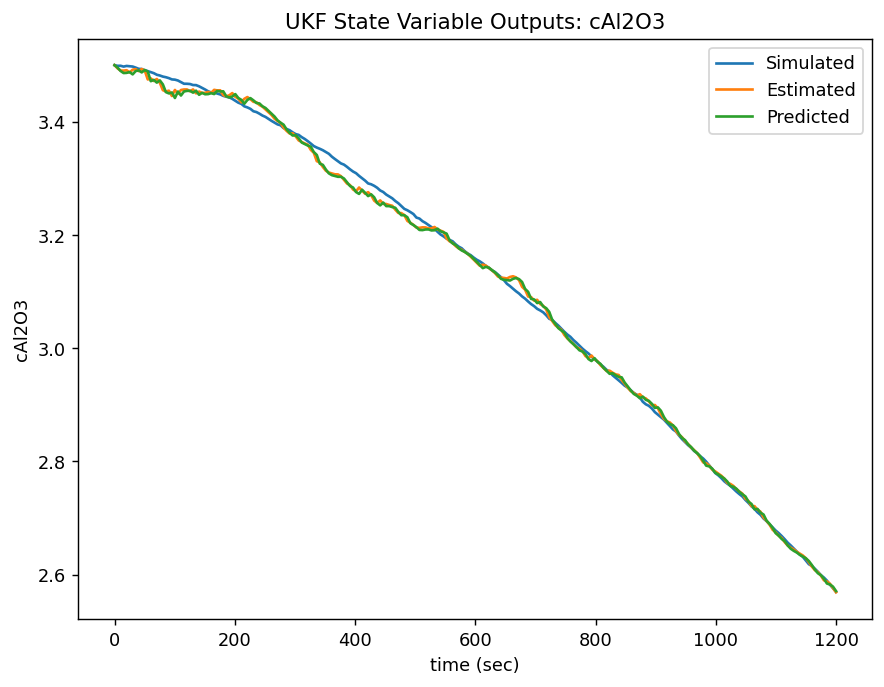

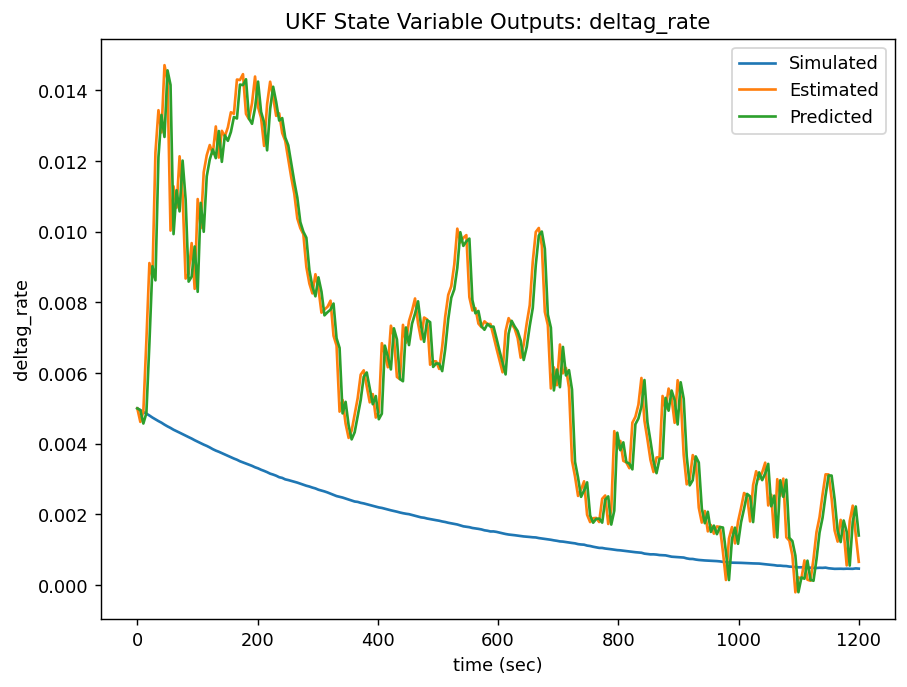

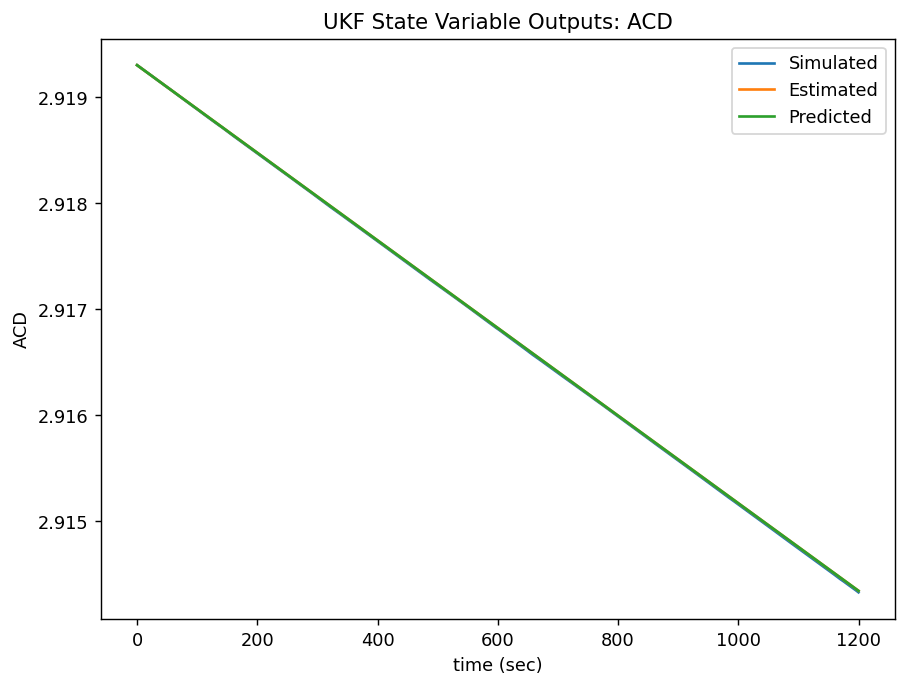

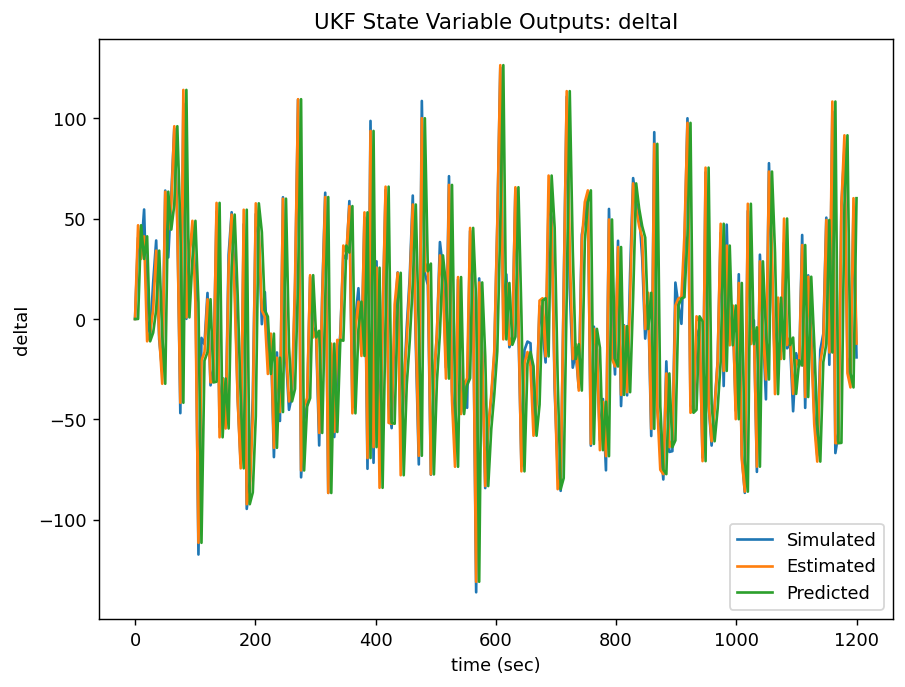

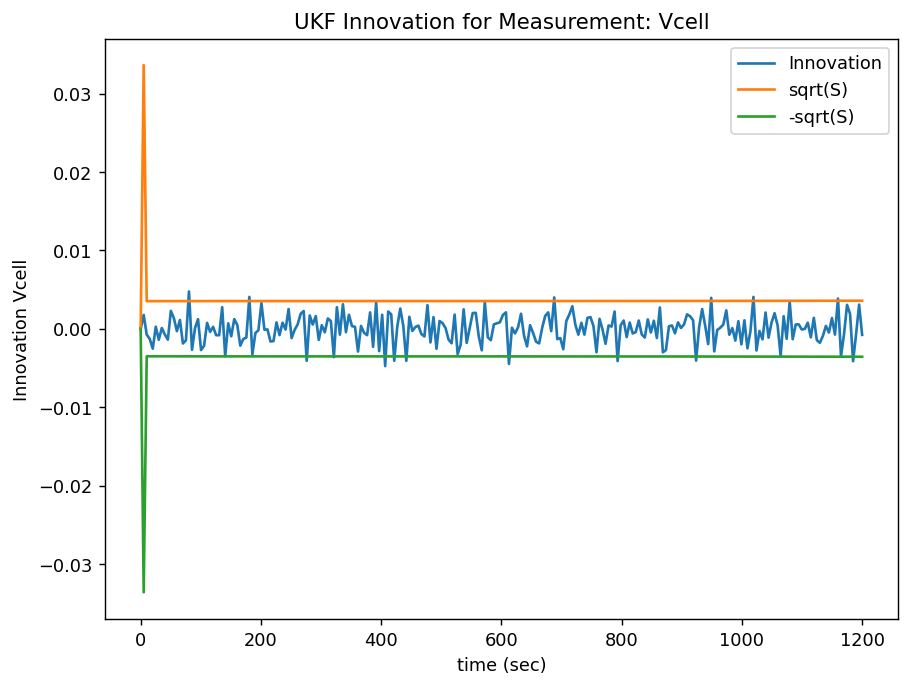

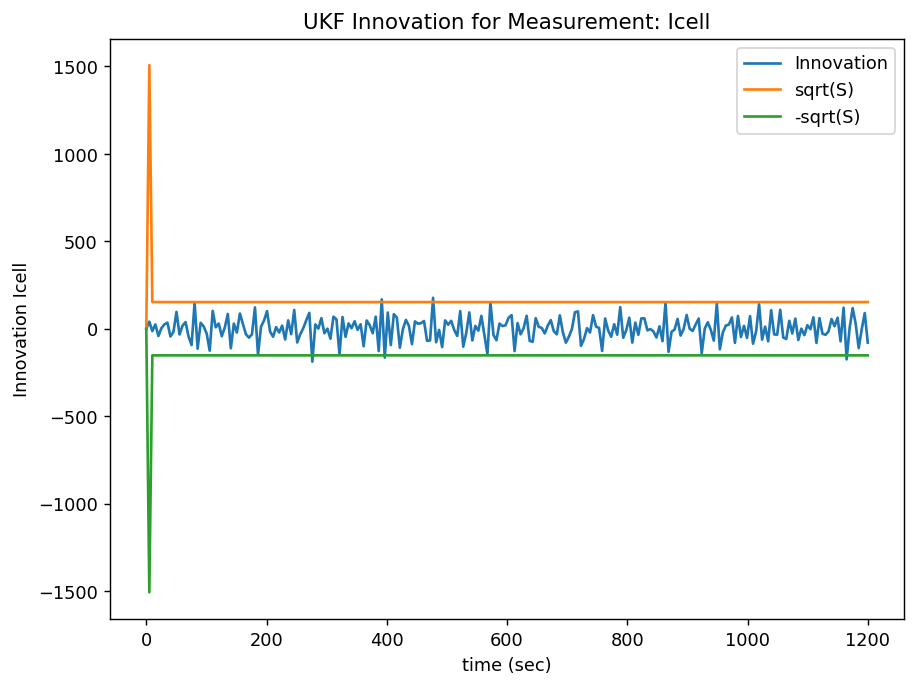

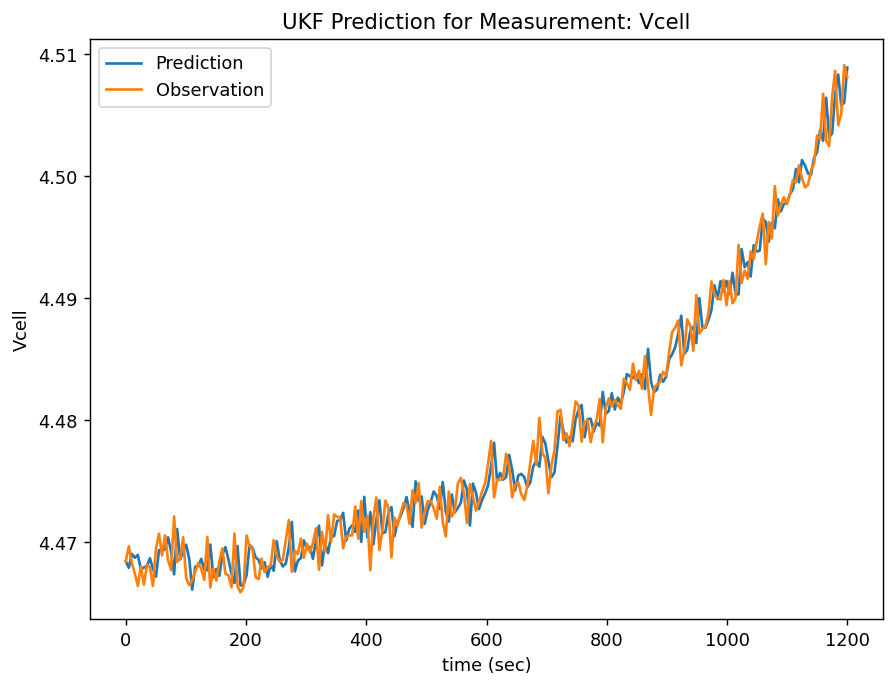

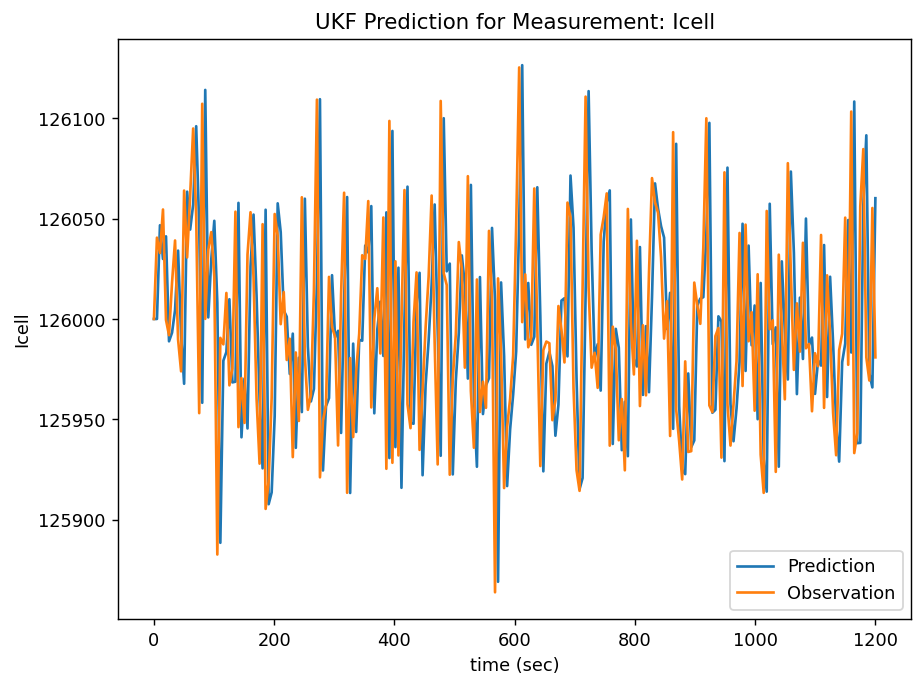

In [70]:
# Run the simulation through the UKF 4 state model 
xest, Pest, xpred, Ppred, innov, innov_cov = ukf_execute(UKF4state, zt, ut, 5, plotresult=True, xtrue=xt)

In [71]:
from Refactor.Simulation import sim_transform

In [72]:
validtfr, xtr, utr, ztr = sim_transform(x, u, z, 126000.0, 100, alumina3state, alumina4state)

In [74]:
np.array_equal(xtr, xt)

True